# **1.Dataset Selection and Preprocessing**

In [2]:
# Import required libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load dataset
file_path = "Mall_Customers.csv"  # Adjust path if running locally
df = pd.read_csv(file_path)

# Drop 'CustomerID' as it's not relevant for clustering
df_cleaned = df.drop("CustomerID", axis=1)

# Encode categorical variable 'Genre' (Female = 0, Male = 1)
le = LabelEncoder()
df_cleaned['Genre'] = le.fit_transform(df_cleaned['Genre'])

# Apply feature scaling to normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cleaned)

# Convert scaled data to DataFrame
df_scaled = pd.DataFrame(scaled_data, columns=df_cleaned.columns)

# Display the first few rows of the scaled dataset
df_scaled.head()


,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1.128152,-1.424569,-1.738999,-0.434801
1,1.128152,-1.281035,-1.738999,1.195704
2,-0.886405,-1.352802,-1.700830,-1.715913
3,-0.886405,-1.137502,-1.700830,1.040418
4,-0.886405,-0.563369,-1.662660,-0.395980


# **2.Clustering**

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [4]:
# --- K-Means Clustering ---
# Determine optimal k using Elbow Method
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

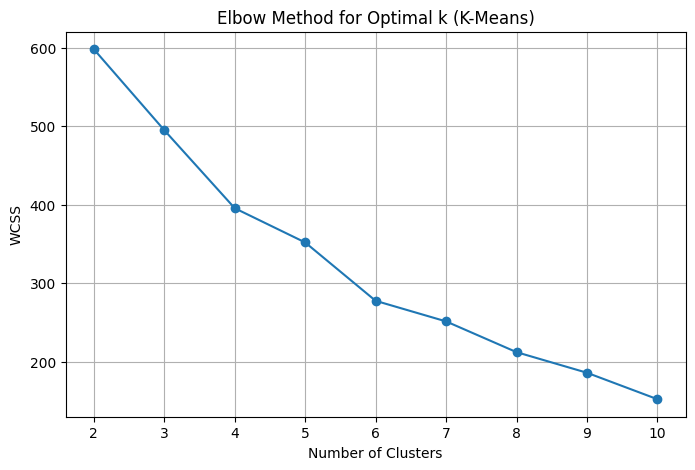

In [5]:
# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k (K-Means)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [6]:
# Apply K-Means with optimal k = 5
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(df_scaled)
df_scaled['Cluster_KMeans'] = kmeans_labels


In [7]:
# Silhouette Score for K-Means
kmeans_silhouette = silhouette_score(df_scaled.drop('Cluster_KMeans', axis=1), kmeans_labels)
print("K-Means Silhouette Score:", kmeans_silhouette)

K-Means Silhouette Score: 0.27191023466188324


In [8]:
# --- Hierarchical Clustering ---
# Create linkage matrix
linked = linkage(df_scaled.drop('Cluster_KMeans', axis=1), method='ward')

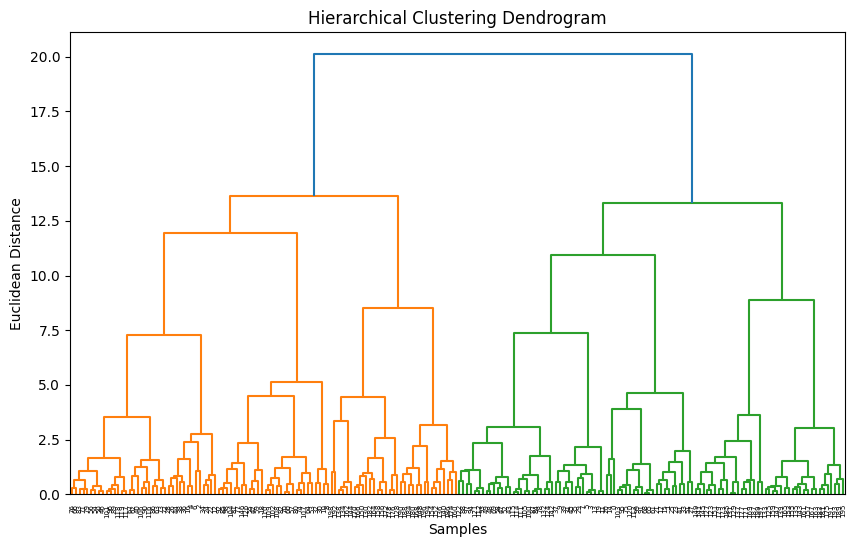

In [9]:
# Dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Euclidean Distance')
plt.show()

In [10]:
# Cut dendrogram to form 5 clusters
hierarchical_labels = fcluster(linked, t=5, criterion='maxclust')
df_scaled['Cluster_Hierarchical'] = hierarchical_labels


In [11]:
# Silhouette Score for Hierarchical
hierarchical_silhouette = silhouette_score(
    df_scaled.drop(['Cluster_KMeans', 'Cluster_Hierarchical'], axis=1),
    hierarchical_labels
)
print("Hierarchical Clustering Silhouette Score:", hierarchical_silhouette)


Hierarchical Clustering Silhouette Score: 0.28699413201651747


In [12]:
# --- Cluster Visualization using PCA ---
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_scaled.drop(['Cluster_KMeans', 'Cluster_Hierarchical'], axis=1))

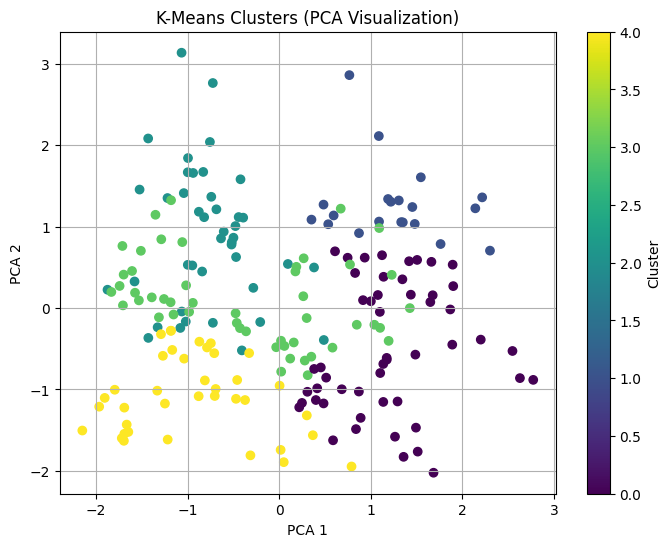

In [13]:
# Visualize K-Means Clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('K-Means Clusters (PCA Visualization)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

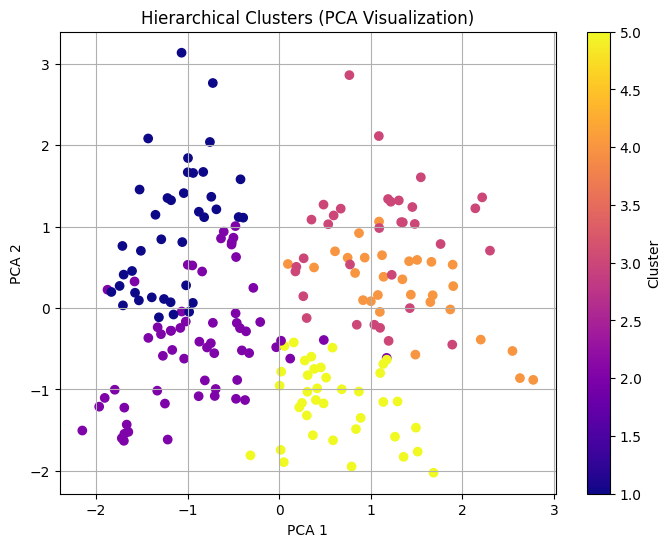

In [14]:
# Visualize Hierarchical Clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=hierarchical_labels, cmap='plasma')
plt.title('Hierarchical Clusters (PCA Visualization)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# **Step 3. Dimensionality Reduction**

In [15]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [16]:
# Drop cluster labels to prepare features for dimensionality reduction
features = df_scaled.drop(['Cluster_KMeans', 'Cluster_Hierarchical'], axis=1)

In [17]:
#PCA: Explained Variance
pca_full = PCA()
pca_full.fit(features)

PCA()

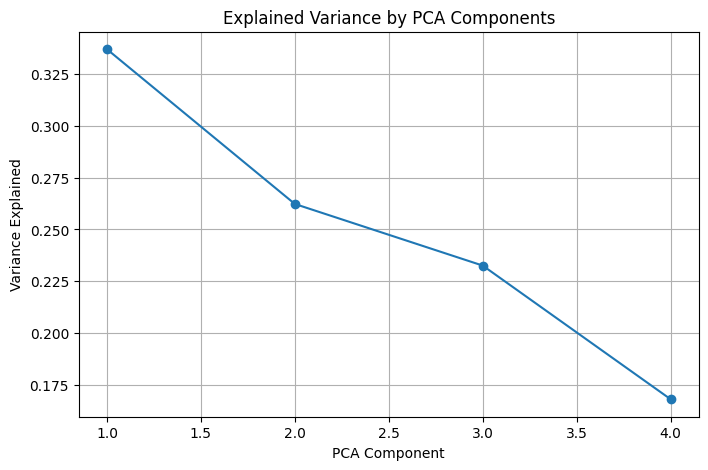

In [18]:
# Plot variance explained by each PCA component
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1), pca_full.explained_variance_ratio_, marker='o')
plt.title('Explained Variance by PCA Components')
plt.xlabel('PCA Component')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.show()


In [19]:
#t-SNE: 2D Projection for Visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_components = tsne.fit_transform(features)

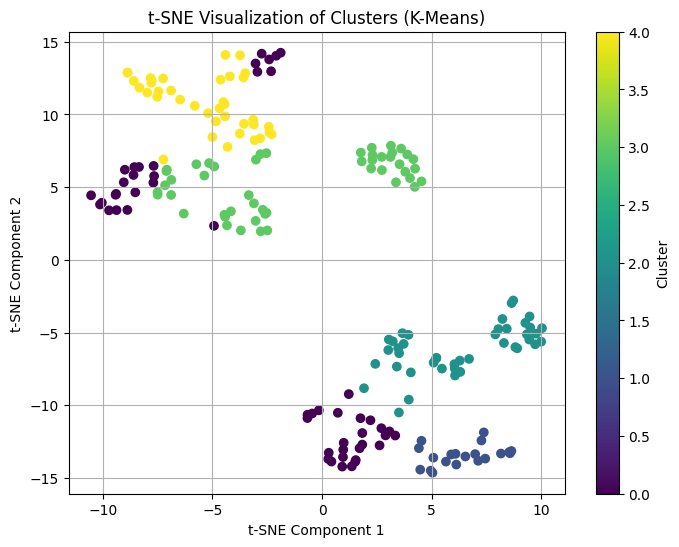

In [20]:
# Visualize t-SNE output using K-Means cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(tsne_components[:, 0], tsne_components[:, 1], c=df_scaled['Cluster_KMeans'], cmap='viridis')
plt.title('t-SNE Visualization of Clusters (K-Means)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# **Step 4: Model Evaluation**

In [21]:
from sklearn.metrics import silhouette_score
import pandas as pd

# Remove cluster labels to get feature matrix
features = df_scaled.drop(['Cluster_KMeans', 'Cluster_Hierarchical'], axis=1)


In [22]:
# Calculate Silhouette Scores
kmeans_score = silhouette_score(features, df_scaled['Cluster_KMeans'])
hierarchical_score = silhouette_score(features, df_scaled['Cluster_Hierarchical'])

In [23]:
# Create summary table
evaluation_summary = pd.DataFrame({
    'Clustering Method': ['K-Means', 'Hierarchical'],
    'Silhouette Score': [kmeans_score, hierarchical_score]
})

In [24]:
# Display results
print(evaluation_summary)

  Clustering Method  Silhouette Score
0           K-Means          0.271910
1      Hierarchical          0.286994


# **Step 5. Deployment and Monitoring**

In [25]:
import joblib
import numpy as np

# Save the KMeans model and scaler for production use
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [28]:
# Define a function that simulates future input data and assigns clusters
def predict_cluster(new_data):
    """
    Simulates a production environment where new customer data is provided.
    new_data should be a dictionary with keys: 'Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'
    """
     # Load models
    kmeans_loaded = joblib.load('kmeans_model.pkl')
    scaler_loaded = joblib.load('scaler.pkl')

    # Prepare input
    df_input = pd.DataFrame([new_data])
    df_input['Genre'] = le.transform(df_input['Genre'])  # Encode 'Genre'
    scaled_input = scaler_loaded.transform(df_input)

    # Predict cluster
    cluster = kmeans_loaded.predict(scaled_input)
    return int(cluster[0])

In [29]:
# Example usage: New customer
new_customer = {
    'Genre': 'Female',
    'Age': 29,
    'Annual Income (k$)': 55,
    'Spending Score (1-100)': 72
}
predicted_cluster = predict_cluster(new_customer)
print(f"Predicted cluster for new customer: {predicted_cluster}")

Predicted cluster for new customer: 4


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
